# Software Evolution - Practical Session
## Laws of software evolution based on code counting
## Academic year 2023-2024

### Write your answers under the questions that are present in this notebook  

#### Note: Print the final output of each cell in this notebook

#### Read the provided description document before proceeding with the following notebook

## 1.  Data preprocessing

To install packages, use :

pip install tqdm  pandas numpy matplotlib scikit-learn

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from permetrics.regression import RegressionMetric
from scipy.optimize import curve_fit

### Import dataset

First, import the dataset that contains the total lines of code, total blank lines, total comment lines, total number of files, and release date for each tag.

In [51]:
# WRITE YOUR CODE HERE
df = pd.read_csv('data/LawIncreasingGrowthDataset.csv')
print(df)

        tag    code  blank  comment  nFiles release_date
0       1.4   48551   8727    11154     419   2009-01-06
1     1.5.0   63240  11018    18457     512   2009-02-18
2    jaunty   70751  11840    19671     578   2009-06-23
3     1.5.1   67939  11618    18131     600   2009-08-05
4     1.5.2   68564  11555    11906     611   2009-08-17
..      ...     ...    ...      ...     ...          ...
56    4.3.1  456159  72232   219480    3405   2016-12-14
57  4.3.1.1  456159  72232   219480    3405   2017-02-02
58    4.4.0  472926  75325   216544    3597   2017-03-07
59    4.4.1  473836  75392   216678    3598   2017-05-08
60    4.4.2  474213  75436   216751    3599   2017-08-30

[61 rows x 6 columns]


### Dataset A : Major.Minor.Patch tag format

Filter out non-official releases such as alpha, beta, release candidates, milestones, branches, and unnumbered tags. Additionally, version numbers typically follow a Major.Minor.Patch format, but exceptions exist (e.g., 1.4, 3.3.0.1, 4.3.0.1, or 4.3.1.1). Versions with more than three components are disregarded, and two-component versions are treated as implicit three-component versions (e.g., 1.4 is interpreted as 1.4.0).  

Write a regular expression statement to identify tags following semantic versioning (major.minor.patch) guidelines. You can use the pattern: '^v?[0-9]+\.[0-9]+(\.[0-9]+)?$'  

Once you've applied this regex, print out the selected major.minor.patch dataset.

In [52]:
# WRITE YOUR CODE HERE
import re

for ind in df.index:
    if re.search('^v?[0-9]+\.[0-9]+(\.[0-9]+)?$', df['tag'][ind]) is not None:
        if df['tag'][ind].count('.') == 1:
            df.loc[ind, 'tag'] = df['tag'][ind] + '.0'
    else:
        df = df.drop(labels=ind, axis=0)

print(df)

      tag    code  blank  comment  nFiles release_date
0   1.4.0   48551   8727    11154     419   2009-01-06
1   1.5.0   63240  11018    18457     512   2009-02-18
3   1.5.1   67939  11618    18131     600   2009-08-05
4   1.5.2   68564  11555    11906     611   2009-08-17
6   1.6.1   86799  14582    41327     744   2009-11-05
9   2.0.0  115586  18488    42717    1074   2010-06-05
10  2.0.1  115699  18492    42724    1074   2010-07-06
21  3.0.0  188246  29836    60879    1694   2012-02-07
22  3.0.1  189022  29945    61587    1696   2012-03-12
26  3.1.0  191269  29973    62628    1642   2012-06-22
27  3.1.1  192026  30086    62931    1645   2012-09-17
28  3.1.2  192113  30101    62959    1646   2012-09-27
29  3.2.0  257934  43596   119688    2004   2012-12-17
33  3.2.1  260231  43992   120082    2011   2013-02-28
36  3.2.2  260173  43974   120045    2007   2013-04-16
38  3.3.0  350914  58798   159566    2682   2013-06-20
40  3.3.1  359678  60196   161364    2760   2013-09-11
41  3.3.2 

### Dataset B : Major.Minor tag format

Starting from the previous data (**Dataset A**),  for each Major.Minor.Patch tag group, select the earliest version (e.g., for a set of 4.4.0, 4.4.1, and 4.4.2, consider 4.4.0 and rename it to 4.4).

In [53]:
# WRITE YOUR CODE HERE
df['Major_Minor'] = df['tag'].apply(lambda x: '.'.join(x.split('.')[:2]))
earliest_versions = df.groupby('Major_Minor', as_index=False).first()
earliest_versions.drop(columns=['Major_Minor'], inplace=True)
earliest_versions['tag'] = earliest_versions['tag'].str.extract(r'^(\d+.\d+)')
print(earliest_versions)

    tag    code  blank  comment  nFiles release_date
0   1.4   48551   8727    11154     419   2009-01-06
1   1.5   63240  11018    18457     512   2009-02-18
2   1.6   86799  14582    41327     744   2009-11-05
3   2.0  115586  18488    42717    1074   2010-06-05
4   3.0  188246  29836    60879    1694   2012-02-07
5   3.1  191269  29973    62628    1642   2012-06-22
6   3.2  257934  43596   119688    2004   2012-12-17
7   3.3  350914  58798   159566    2682   2013-06-20
8   3.4  291555  48371   149981    2367   2013-10-24
9   4.0  357375  57707   159944    2790   2014-05-30
10  4.1  419663  68854   208270    3283   2015-01-28
11  4.2  438240  71324   218459    3439   2015-10-22
12  4.3  455646  72172   219435    3405   2016-08-09
13  4.4  472926  75325   216544    3597   2017-03-07


## 2. Law of Increasing Growth

### Software project's metrics

Visualize four plots representing the evolution of a software project's metrics, including the number of lines of code, blank lines, comment lines, and the number of files, as follows:  

1. Plot the metrics against software version numbers:  
   1.1) For version tags of the format major.minor.patch.  
   1.2) For version tags of the format major.minor.  
   Place these plots at positions (0,0) and (0,1) respectively.  
  
2. Plot the metrics against dates:  
   2.1) For version tags of the format major.minor.patch.  
   2.2) For version tags of the format major.minor.  
   Place these plots right below the corresponding version-based plots, at positions (1,0) and (1,1).  

Hint: Ensure proper datetime formatting for the dates in the datasets instead of storing them as strings.

For example, if you're working with a DataFrame:

fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
dataset_a[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)  
.....  

axes[0, 0].set_xlabel('Major.Minor.Patch versions')  
.....  

plt.tight_layout()  
plt.show()

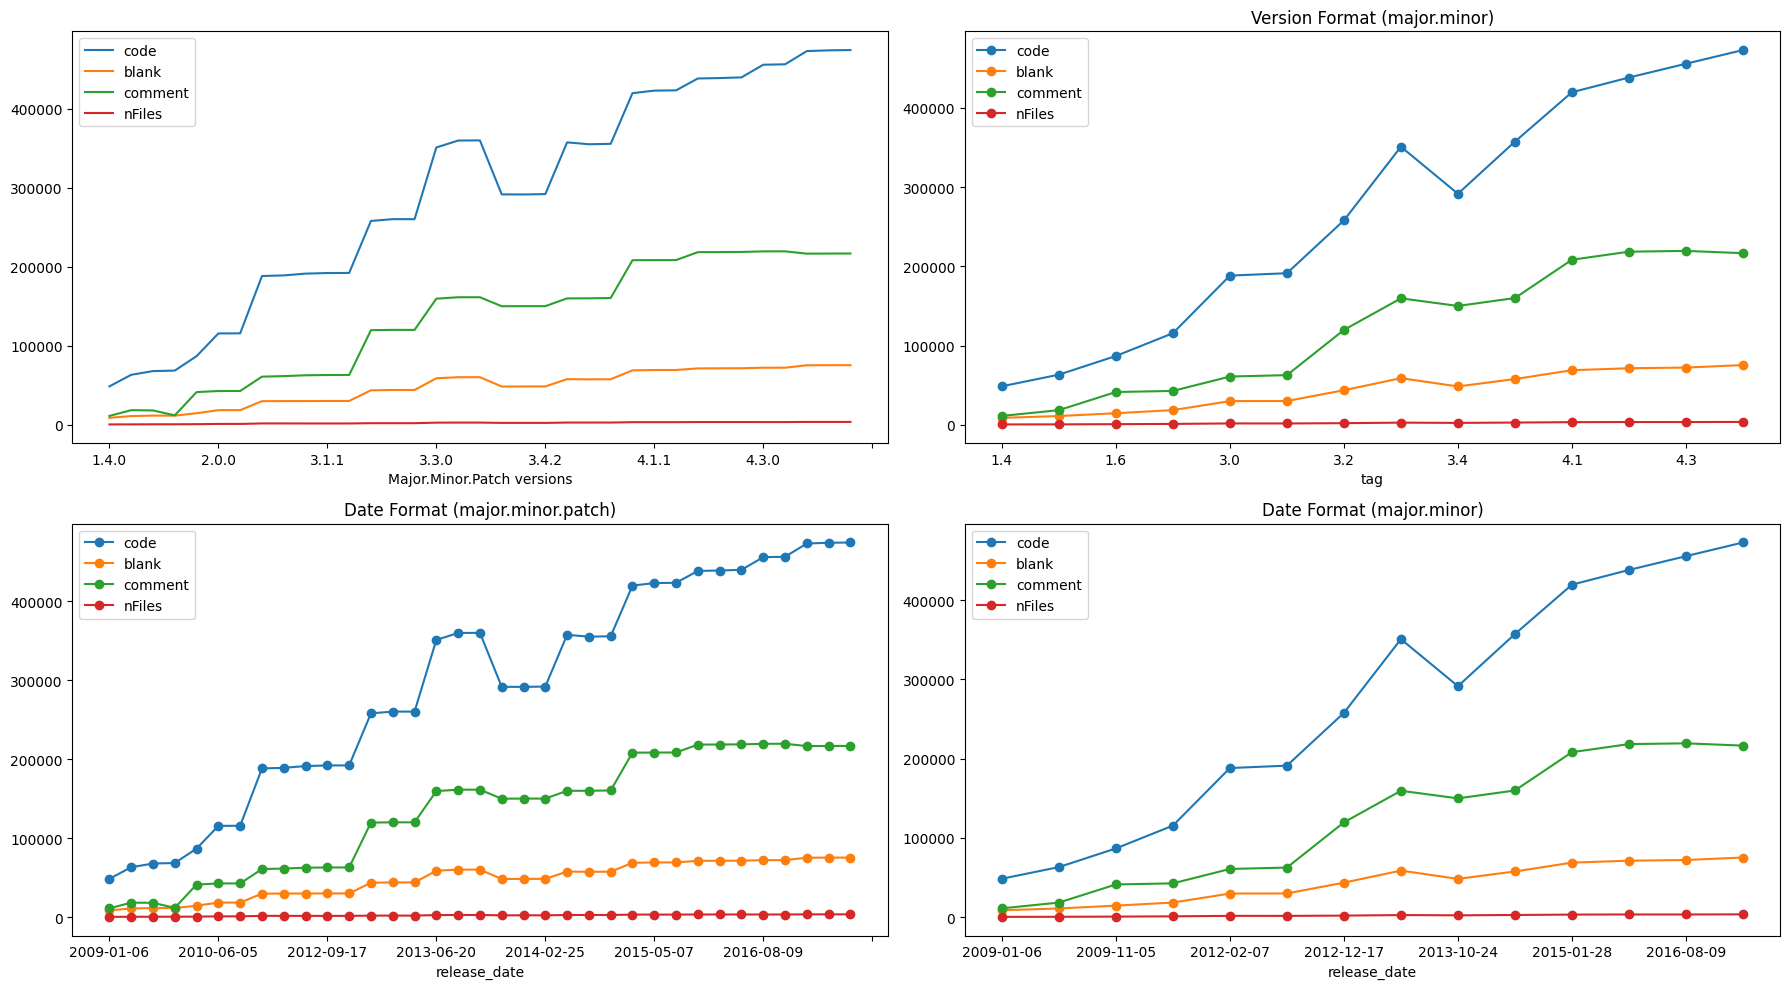

In [54]:
# WRITE YOUR CODE HERE
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
df[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)    

axes[0, 0].set_xlabel('Major.Minor.Patch versions')  


# Plotting against software version numbers (major.minor)
earliest_versions[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag',  ax=axes[0, 1], marker='o')
axes[0, 1].set_title('Version Format (major.minor)')

# Plotting against dates (major.minor.patch)
df[['code', 'blank', 'comment', 'nFiles', 'tag','release_date']].plot(x='release_date', ax=axes[1, 0], marker='o')
axes[1, 0].set_title('Date Format (major.minor.patch)')

# Plotting against dates (major.minor)
earliest_versions[['code', 'blank', 'comment', 'nFiles', 'tag','release_date']].plot(x='release_date', ax=axes[1, 1], marker='o')
axes[1, 1].set_title('Date Format (major.minor)')

plt.tight_layout()  
plt.show()

### Questions:

1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

There is no difference, as tags reflect release dates it makes sense to see the same growth.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

a) because tag can be changed but release dates can't

### Correlation 

Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering **Dataset A**. Report the correlation upto 3 decimal places.

In [55]:
# WRITE YOUR CODE HERE
from scipy.stats import spearmanr, pearsonr
spearman_corr, spearman_p_value = spearmanr(df['code'], df['nFiles'])

# Calculate Pearson correlation
pearson_corr, pearson_p_value = pearsonr(df['code'], df['nFiles'])

# Report the correlations
print(f"Spearman correlation: {spearman_corr:.3f}")
print(f"Pearson correlation: {pearson_corr:.3f}")

Spearman correlation: 0.986
Pearson correlation: 0.998


### Questions:

3. Do you find any difference in correlation values between Pearson and Spearman? Which correlation measure is preferable for this use case? why?

Yes but very little, 

4. Based on the above correlation value, please give your opinion on the relation between the number of lines and the number of files? Which of both size metrics do you propose to use in the remainder of your analysis?

It looks like we have a high correlation between the two. Meaning that increasing the number of lines also increase the number of files and vice versa. 

### Regression analysis

Visualize a linear regression analysis of the relationship between the release date and the total number of files by considering **Dataset B**.  

Hint:

1. Prepare the data: Convert the release date to integers and set number of files as the target variable.  
2. Apply linear regression analysis to understand the relationship between the release date and the total number of files.  
3. Calculate Mean Relative Error and ajusted R-squared metrics.    
4. Generate a scatter plot showing the release dates against the total number of files. Then, overlay the linear regression line on the plot.


Mean Relative Error: 8.46%
Adjusted R-squared: 0.9729


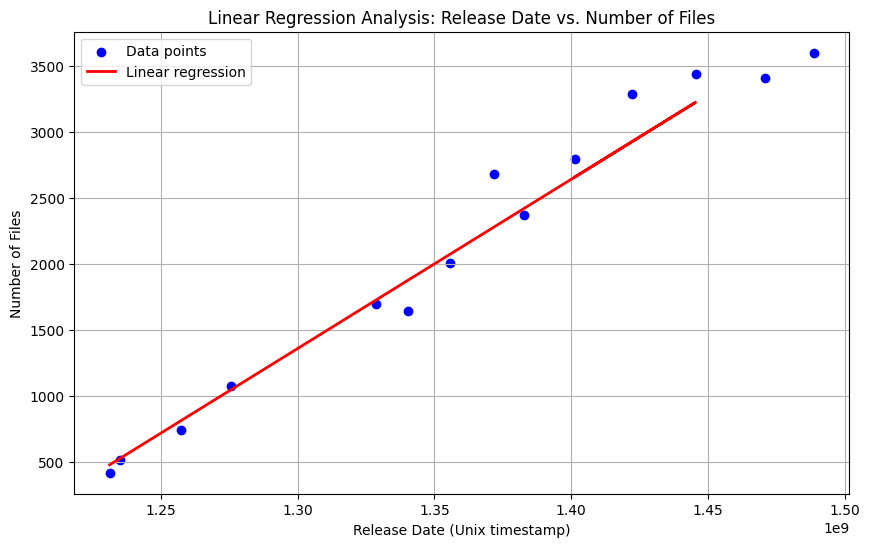

In [56]:
# WRITE YOUR CODE HERE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Step 1: Prepare the data
earliest_versions['release_date'] = pd.to_datetime(earliest_versions['release_date'])
earliest_versions['release_date_int'] = earliest_versions['release_date'].astype(np.int64) // 10**9  # Convert to integer (seconds since epoch)

X = earliest_versions[['release_date_int']]  # Independent variable
y = earliest_versions['nFiles']  # Target variable

# Step 2: Apply linear regression analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Step 3: Calculate Mean Relative Error and adjusted R-squared metrics
y_pred = model.predict(X_test)

mean_relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
adjusted_r2 = 1 - (1 - r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"Mean Relative Error: {mean_relative_error:.2f}%")
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

# Step 4: Generate scatter plot with linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(earliest_versions['release_date_int'], earliest_versions['nFiles'], color='blue', label='Data points')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linear regression')
plt.xlabel('Release Date (Unix timestamp)')
plt.ylabel('Number of Files')
plt.title('Linear Regression Analysis: Release Date vs. Number of Files')
plt.legend()
plt.grid(True)
plt.show()

### Questions:

5. Choose an option regarding the growth of the software. Motivate your choice using the 2D regression plot.  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

Linear 

6. Report the MRE and ajusted R-squared values.

MRE : 8.46%
R-squared : 0.9729

### Fitting & forecasting

Using **Dataset A**, apply parametric regression models (e.g., linear, exponential, power, quadratic, logarithmic) to predict the number of files in software releases based on historical data.

**Steps:**

1. Prepare Data:
   - Convert "release_date" to datetime format.
   - Calculate "release_days" as the number of days since the earliest release.

2. Split Data:
   - Separate data into features (release days) and target variable (number of files).
   - Split data into training and testing sets from the earliest release up to a specific point.

3. Build and Train Models:
   - Define regression models.
   - Fit models to training data (maybe using `curve_fit` from SciPy).

4. Forecast Future Data:
   - Predict the number of files for future release days using trained models.

5. Visualize Results:
   - Plot original data and forecasted values for each regression model.

6. Evaluate Models:
   - Calculate adjusted R-squared and mean relative error for each model using training and test data.

In [57]:
# WRITE YOUR CODE HERE
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_days'] = (df['release_date'] - df['release_date'].min()).dt.days

In [58]:
# WRITE YOUR CODE HERE
X = df[['release_days']].values
y = df['nFiles'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [59]:
# WRITE YOUR CODE HERE
def linear_model(x, a, b):
    return a * x + b

def exponential_model(x, a, b):
    return a * np.exp(b * x)

def power_model(x, a, b):
    return a * np.power(x, b)

def quadratic_model(x, a, b, c):
    return a * np.power(x, 2) + b * x + c

def logarithmic_model(x, a, b):
    return a * np.log(x) + b

models = {
    'Linear': linear_model,
    'Exponential': exponential_model,
    'Power': power_model,
    'Quadratic': quadratic_model,
    'Logarithmic': logarithmic_model
}

trained_models = {}
for name, model in models.items():
    popt, _ = curve_fit(model, X_train.flatten(), y_train)
    trained_models[name] = (model, popt)

/tmp/ipykernel_1360/3479349478.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)
/var/data/python/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:980: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/tmp/ipykernel_1360/3479349478.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model, X_train.flatten(), y_train)
/tmp/ipykernel_1360/3479349478.py:15: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b


In [60]:
# WRITE YOUR CODE HERE
future_days = np.arange(df['release_days'].min(), df['release_days'].max() + 50)  # Extend 50 days into future

forecasted_values = {}
for name, (model, popt) in trained_models.items():
    forecasted_values[name] = model(future_days, *popt)

/tmp/ipykernel_1360/3479349478.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)
/tmp/ipykernel_1360/3479349478.py:15: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b


/var/data/python/lib/python3.11/site-packages/matplotlib/ticker.py:2096: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


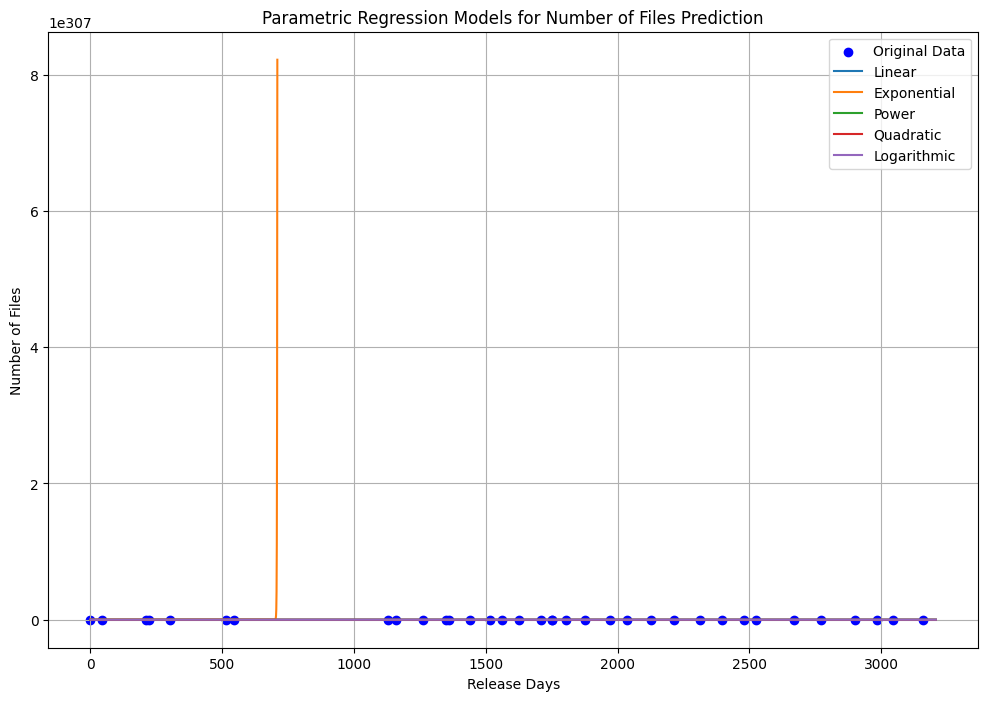

In [61]:
# WRITE YOUR CODE HERE
plt.figure(figsize=(12, 8))
plt.scatter(df['release_days'], df['nFiles'], label='Original Data', color='blue')

for name, values in forecasted_values.items():
    plt.plot(future_days, values, label=name)

plt.xlabel('Release Days')
plt.ylabel('Number of Files')
plt.title('Parametric Regression Models for Number of Files Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# WRITE YOUR CODE HERE
def evaluate_model(model, X, y):
    y_pred = model(X.flatten(), *popt)
    r2 = r2_score(y, y_pred)
    mean_relative_error = np.mean(np.abs((y - y_pred) / y)) * 100
    return r2, mean_relative_error

print("Evaluation Results:")
for name, (model, popt) in trained_models.items():
    train_r2, train_mean_relative_error = evaluate_model(model, X_train, y_train)
    test_r2, test_mean_relative_error = evaluate_model(model, X_test, y_test)
    print(f"Model: {name}")
    print(f"Train R-squared: {train_r2:.4f}, Train Mean Relative Error: {train_mean_relative_error:.2f}%")
    print(f"Test R-squared: {test_r2:.4f}, Test Mean Relative Error: {test_mean_relative_error:.2f}%")
    print()

Evaluation Results:
Model: Linear
Train R-squared: 0.9588, Train Mean Relative Error: 8.36%
Test R-squared: -17.0331, Test Mean Relative Error: 9.34%



/tmp/ipykernel_1360/3479349478.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * x)


ValueError: Input contains infinity or a value too large for dtype('float64').

### Questions:

7. Which regression model do you prefer for assessing the goodness of fit, based on the evaluation metrics scores? Why?

8. Which regression model do you prefer for assessing forecast accuracy, based on the evaluation metrics scores? Why?

### Modify the CLOC parameters

Exclude all bank lines and verify if the Law of Increasing Growth applies after this filtering

In [ ]:
# WRITE YOUR CODE HERE

Exclude all comment lines and verify if the Law of Increasing Growth applies after this filtering

In [ ]:
# WRITE YOUR CODE HERE

## 3. Law of Continuing Change

### Dataset A : Major.Minor.Patch tag format

Import Dataset A that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the three component versions (major.minor.patch)

In [ ]:
# WRITE YOUR CODE HERE

Create a plot displaying all features together. Show the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

In [ ]:
# WRITE YOUR CODE HERE

### Dataset B : Major.Minor tag format

Import Dataset B that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the minor versions (major.minor)

In [ ]:
# WRITE YOUR CODE HERE

Produce a plot where all features are represented together. Present the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

In [ ]:
# WRITE YOUR CODE HERE

### Question:

1. Do you find empirical support for the Law of Continuing Change ? Motivate your response.